# Análise do COVID-19 com Spark

Utilizando o Spark para leitura e tratamento dos dados de casos de COVID-19 reportados ao SUS no Brasil*, iremos responder às seguintes perguntas:
* Qual o número de casos e mortes (absoluto e percentual) por raça, faixa etária e escolaridade?
* Quais os sitomas reportados mais comuns para os que se curaram e os que sobreviveram?
* Qual é o perfil da população mais suscetível à morte, considerando faixa etária, escolaridade, região do país e fatores de risco?

*_arquivo de dados baixado de http://plataforma.saude.gov.br/coronavirus/dados-abertos/ atualizado em 18/05/2020_

# Setup inicial

Primeiramente vamos criar a Spark Session

In [1]:
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder \
        .master('local[8]') \
        .appName("Covid Renato")\
        .getOrCreate()

In [3]:
spark

In [4]:
sc = spark.sparkContext

E importar o arquivo dados-covid

In [5]:
path = '../data/covid'
datafile = '/dados-covid-200518.csv'

In [6]:
sdf1 = spark.read \
        .option('header', True) \
        .option("delimiter", ";")\
        .csv(path + datafile)

# Tratamento Inicial do banco de dados

In [7]:
from pyspark.sql.types import *

In [8]:
from pyspark.sql import functions as sf

In [9]:
from pyspark.sql.functions import *

In [10]:
from pyspark.sql.window import Window

Lendo o dicionário do banco de dados, vamos trabalhar com as seguintes variáveis: <br>

**Perfil demográfico do paciente:** 
SG_UF_NOT , 
CS_SEXO ,
NU_IDADE_N ,
TP_IDADE,
CS_RACA ,
CS_ESCOL_N ,
CS_ZONA<br>
**35 - sintomas:** (FEBRE, TOSSE, GARGANTA, DISPNEIA, DESC_RESP, SATURACAO, DIARREIA, VOMITO, OUTRO_SIN, OUTRO_DES)<br>
**36- Fatores de risco:** (PUERPERA, CARDIOPATI, HEMATOLOGI, SIND_DOWN, HEPATICA, ASMA, DIABETES, NEUROLOGIC, PNEUMOPATI, IMUNODEPRE, RENAL, OBESIDADE, OUT_MORBI)<br>
**Apenas os casos de COIVD:** CLASSI_FIN (= 5-COVID-19)<br>
**Evolução do paciente**: EVOLUCAO

Assim, vamos reduzir o daataframe considerando apenas nossas variáveis foco.

In [11]:
sdf2 = sdf1.select('SG_UF_NOT','CS_SEXO','NU_IDADE_N','TP_IDADE','CS_RACA','CS_ESCOL_N','CLASSI_FIN','EVOLUCAO',\
                  'FEBRE','TOSSE','GARGANTA','DISPNEIA','DESC_RESP','SATURACAO','DIARREIA','VOMITO',\
                  'OUTRO_SIN','OUTRO_DES','PUERPERA','CARDIOPATI','HEMATOLOGI','SIND_DOWN','HEPATICA',\
                  'ASMA','DIABETES','NEUROLOGIC','PNEUMOPATI','IMUNODEPRE','RENAL','OBESIDADE','OUT_MORBI', 'PCR_SARS2')\
                    .filter(sdf1['CLASSI_FIN'] == '5')

Também vamos criar uma coluna com o percentual de cada linha para facilitar cálculos

In [12]:
total = sdf2.select('SG_UF_NOT').count()
sdf3 = sdf2.withColumn('percent', sf.lit(1/total))

# Analise o número de casos e mortes

### Análise geral:

Primeiro, vamos analisar os casos de COVID pelo tipo de evolução do caso: 

In [13]:
table1 = sdf3.groupBy('EVOLUCAO').agg(sf.count('SG_UF_NOT').alias('Count'),\
                                      round(sf.sum('percent')*100).alias('Percent'))\
                                    .sort(col('EVOLUCAO').asc()).toPandas()
table1

,EVOLUCAO,Count,Percent
0,None,11716,27.0
1,1,16435,37.0
2,2,13558,31.0
3,9,2197,5.0


In [14]:
import matplotlib.pyplot as plt
import numpy as np

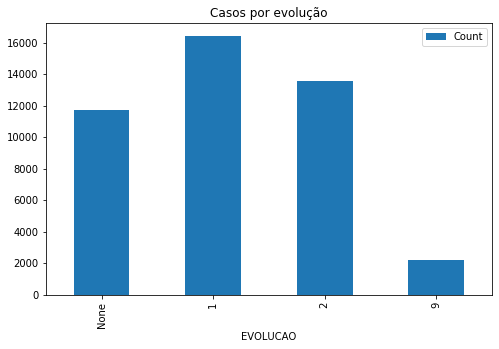

In [15]:
table1.plot(x ='EVOLUCAO', y='Count', kind = 'bar',figsize = (8,5),title = 'Casos por evolução')

Avaliando os casos por evolução, vemos que não há dados para quase um terço do levantamento (Evolucao == None ou 9).<br>
Também notamos que os casos confirmados de Cura (Evolucao == 1) e Óbito (Evolucao == 2) são muito próximos; no entanto, se considerarmos os pacientes sem evolução como curados, teremos uma taxa de recuperação de 69%.<br>
De qualquer forma, podemos concluir que a taxa de mortalidade de pacientes que são hospitalizados (31%) é muito maior do que vemos reportado em geral na população em geral - pelo site da bing (https://www.bing.com/covid) está em 5,5% em 13.jun.2020

### Análise por cor da pele do paciente:

Casos de COVID por cor de pele

In [16]:
table2 = sdf3.groupBy('CS_RACA').agg(sf.count('SG_UF_NOT').alias('Count_caso'),\
                                    round(sf.sum('percent')*100).alias('Percent_caso'))\
                                .orderBy('CS_RACA', ascending=True).toPandas()

table2

,CS_RACA,Count_caso,Percent_caso
0,None,8504,19.0
1,1,13838,32.0
2,2,1972,4.0
3,3,449,1.0
4,4,11214,26.0
5,5,81,0.0
6,9,7848,18.0


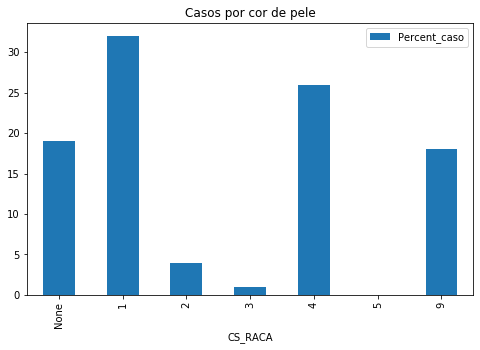

In [17]:
table2.plot(x ='CS_RACA', y='Percent_caso', kind = 'bar',figsize = (8,5),title = 'Casos por cor de pele')


Em relação ao número de pacientes hospitalizados por cor da pele, vemos que em 37% dos casos, a informação não foi coletada.<br>
Nos casos em que foi coletado, o maior grupo são os 1-Branca (32%), seguidos por 4-Pardo (26%), 2-Preta (4%). Cor 3-Amarela e 5-Indígena somam 1%.

Mortes por cor de pele:

In [18]:
table3 = sdf3.groupBy('CS_RACA', 'EVOLUCAO').agg(sf.count('SG_UF_NOT').alias('Count_morte'))\
                    .where(sdf3['EVOLUCAO']=='2').orderBy('CS_RACA', ascending=True)\
                    .withColumn('Percent_morte', round(100*sf.col('Count_morte')/sf.sum('Count_morte').over(Window.partitionBy())))\
                    .toPandas()\
  
table3

,CS_RACA,EVOLUCAO,Count_morte,Percent_morte
0,None,2,2507,18.0
1,1,2,3788,28.0
2,2,2,684,5.0
3,3,2,146,1.0
4,4,2,4226,31.0
5,5,2,38,0.0
6,9,2,2169,16.0


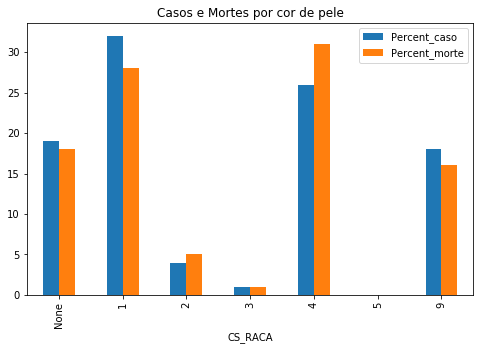

In [19]:
import pandas as pd
table3_2 = pd.concat([table2, table3.drop(['CS_RACA'], axis=1)], axis=1, sort=False,join='inner')
table3_2.plot(x ='CS_RACA', y= ['Percent_caso','Percent_morte'], kind = 'bar',figsize = (8,5),\
              title = "Casos e Mortes por cor de pele" )


Analisando as mortes, vemos que o percentual de 4-Pardo passa a liderar com 31% e 2-preta, mesmo que descreto, também tem um aumento na proporção contra a representatividade do número de casos hospitalizados. Por outro lado, 1-Branca cai para 28% dos casos de morte.

### Análise por Escolaridade do paciente:

Casos de COVID por Escolaridade:

In [20]:
table4 = sdf3.groupBy('CS_ESCOL_N').agg(sf.count('SG_UF_NOT').alias('Count_caso'),round(sf.sum('percent')*100).alias('Percent_caso'))\
    .orderBy('CS_ESCOL_N', ascending=True).toPandas()

table4

,CS_ESCOL_N,Count_caso,Percent_caso
0,None,13361,30.0
1,0,751,2.0
2,1,3073,7.0
3,2,2384,5.0
4,3,4986,11.0
5,4,3231,7.0
6,5,382,1.0
7,9,15738,36.0


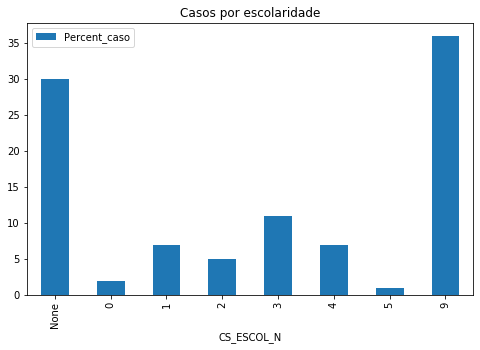

In [21]:
table4.plot(x ='CS_ESCOL_N', y='Percent_caso', kind = 'bar',figsize = (8,5), title = 'Casos por escolaridade')

Novamente vemos a falta de coleta de dados para a maioria dos casos (68%).<br>
Também vemos uma crescente dos números de caso conforme vai aumentando a escolaridade até chegar no 3-Ensino médio e caindo no 4-Ensino Superior.

Mortes por escolaridade:

In [22]:
table4_2 = sdf3.groupBy('CS_ESCOL_N','EVOLUCAO').agg(sf.count('SG_UF_NOT').alias('Count_morte'))\
            .where(sdf3['EVOLUCAO']=='2').orderBy('CS_ESCOL_N', ascending=True)\
            .withColumn('Percent_morte', round(100*sf.col('Count_morte')/sf.sum('Count_morte').over(Window.partitionBy())))\
            .toPandas()
table4_2

,CS_ESCOL_N,EVOLUCAO,Count_morte,Percent_morte
0,None,2,4341,32.0
1,0,2,395,3.0
2,1,2,1259,9.0
3,2,2,808,6.0
4,3,2,1198,9.0
5,4,2,488,4.0
6,5,2,33,0.0
7,9,2,5036,37.0


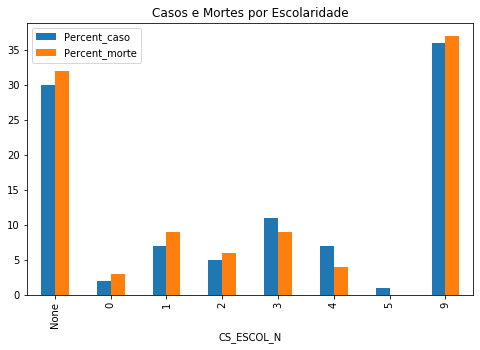

In [23]:
table4_3 = pd.concat([table4, table4_2.drop(['CS_ESCOL_N'], axis=1)], axis=1, sort=False,join='inner')

table4_3.plot(x ='CS_ESCOL_N', y= ['Percent_caso','Percent_morte'], kind = 'bar',figsize = (8,5),\
              title = "Casos e Mortes por Escolaridade" )

Analisando as mortes, vemos um crescimento na concentração nas menores escolaridades (0-Analfabeto,1-Fundamental1,2-Fundamental2) e diminuição nas demais (3-Ensino médio e caindo no 4-Ensino Superior)

### Análise por faixa etária do paciente:

Para fazer análise por faixa etária, vamos criar a classificação agrupando as idades a cada 20 anos. Para essa construção temos que levar em conta que a idade é apresentada em dia, meses ou anos de acordo com a variável TP_IDADE

In [24]:
sdf3 = sdf3.withColumn('FX_IDADE', sf.when(col('TP_IDADE') == '1', '0-20').when(col('TP_IDADE') == '2', '0-20')\
                      .when((col('TP_IDADE') == '3') & (col('NU_IDADE_N') <= 19), '0-20')\
                      .when((col('TP_IDADE') == '3') & (col('NU_IDADE_N') <= 40), '21-40')\
                      .when((col('TP_IDADE') == '3') & (col('NU_IDADE_N') <= 60), '41-60')\
                      .when((col('TP_IDADE') == '3') & (col('NU_IDADE_N') <= 80), '61-80')\
                      .when((col('TP_IDADE') == '3') & (col('NU_IDADE_N') > 80), '80+')\
                      )

In [25]:
sdf3.select('NU_IDADE_N','TP_IDADE','FX_IDADE').where(sdf3['TP_IDADE'] == 3).show(5)

+----------+--------+--------+
|NU_IDADE_N|TP_IDADE|FX_IDADE|
+----------+--------+--------+
|        75|       3|   61-80|
|        28|       3|   21-40|
|        77|       3|   61-80|
|        37|       3|   21-40|
|        69|       3|   61-80|
+----------+--------+--------+
only showing top 5 rows



Com a variável faixa de idade criada podemos analisar o número de casos COVID:

In [26]:
table_idade = sdf3.groupBy('FX_IDADE').agg(sf.count('SG_UF_NOT').alias('Count_caso'),round(sf.sum('percent')*100).alias('Percent_caso'))\
    .orderBy('FX_IDADE', ascending=True).toPandas()

table_idade

,FX_IDADE,Count_caso,Percent_caso
0,0-20,821,2.0
1,21-40,7612,17.0
2,41-60,15785,36.0
3,61-80,14649,33.0
4,80+,5039,11.0


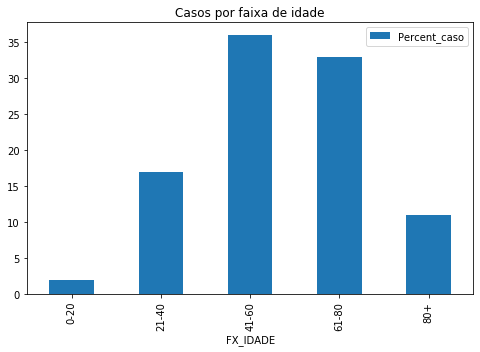

In [27]:
table_idade.plot('FX_IDADE', y='Percent_caso', kind = 'bar',figsize = (8,5), title = 'Casos por faixa de idade')

Vemos que a maior parte dos casos estão concentrados principamente na faixa do 40 aos 80 anos.

Mortes por faixa etária:

In [28]:
table_idade2 = sdf3.groupBy('FX_IDADE','EVOLUCAO').agg(sf.count('SG_UF_NOT').alias('Count_morte'))\
            .where(sdf3['EVOLUCAO']=='2').orderBy('FX_IDADE', ascending=True)\
            .withColumn('Percent_morte', round(100*sf.col('Count_morte')/sf.sum('Count_morte').over(Window.partitionBy())))\
            .toPandas()
table_idade2

,FX_IDADE,EVOLUCAO,Count_morte,Percent_morte
0,0-20,2,81,1.0
1,21-40,2,804,6.0
2,41-60,2,3270,24.0
3,61-80,2,6322,47.0
4,80+,2,3081,23.0


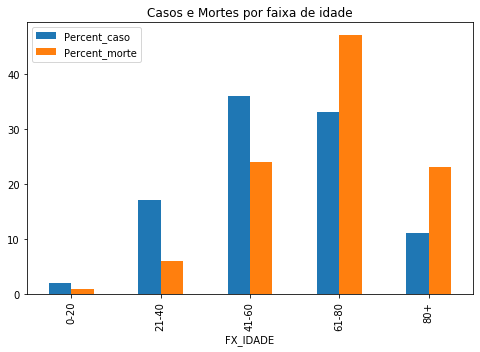

In [29]:
table_idade3 = pd.concat([table_idade, table_idade2.drop(['FX_IDADE'], axis=1)], axis=1, sort=False,join='inner')

table_idade3.plot(x ='FX_IDADE', y= ['Percent_caso','Percent_morte'], kind = 'bar',figsize = (8,5),\
              title = "Casos e Mortes por faixa de idade" )

Analisando as mortes, vemos claramente um aumento na incidência da faixas de 61 anos ou mais.

# Análise dos sitomas

Para a análise dos sintomas, vamos duplicar e limpar as variáveis de sintomas para que apresentem apenas os casos confirmados (=1) igualando as demais informações a zero

In [30]:
colunas = ['FEBRE','TOSSE','GARGANTA','DISPNEIA','DESC_RESP','SATURACAO','DIARREIA','VOMITO']
colunas2 = ['FEBRE2','TOSSE2','GARGANTA2','DISPNEIA2','DESC_RESP2','SATURACAO2','DIARREIA2','VOMITO2']

In [31]:
sdf4 = sdf3
for old, new in zip(colunas, colunas2):
    sdf4 = sdf4.withColumn(new, sf.when(col(old) == '1', 1).otherwise(0))

In [32]:
sdf4.select(colunas2).show(5)

+------+------+---------+---------+----------+----------+---------+-------+
|FEBRE2|TOSSE2|GARGANTA2|DISPNEIA2|DESC_RESP2|SATURACAO2|DIARREIA2|VOMITO2|
+------+------+---------+---------+----------+----------+---------+-------+
|     0|     1|        0|        1|         0|         0|        0|      0|
|     1|     1|        1|        0|         0|         0|        0|      0|
|     1|     1|        0|        1|         0|         1|        1|      1|
|     1|     1|        1|        0|         1|         0|        1|      1|
|     1|     1|        0|        1|         1|         1|        1|      0|
+------+------+---------+---------+----------+----------+---------+-------+
only showing top 5 rows



Vamos criar a tabela resumo com a quantidade de pessoas que apresentaram cada sintoma, agrupado pela Evolução do paciente.

In [33]:
table5 = sdf4.groupBy('EVOLUCAO').agg(sf.count('CS_SEXO'),sf.sum('FEBRE2'),sf.sum('TOSSE2'),\
                             sf.sum('GARGANTA2'),sf.sum('DISPNEIA2'),sf.sum('DESC_RESP2')\
                            ,sf.sum('SATURACAO2'),sf.sum('DIARREIA2'),sf.sum('VOMITO2'))\
        .orderBy('EVOLUCAO', ascending=True)


E vamos adicionar o percentual da ocorrência dos sintomas por Evolução do paciente

In [34]:
coluna = ['count(CS_SEXO)','sum(FEBRE2)','sum(TOSSE2)','sum(GARGANTA2)','sum(DISPNEIA2)','sum(DESC_RESP2)','sum(SATURACAO2)','sum(DIARREIA2)','sum(VOMITO2)']
coluna2 = ['COUNT%','FEBRE%','TOSSE%','GARGANTA%','DISPNEIA%','DESC_RESP%','SATURACAO%','DIARREIA%','VOMITO%']

for old, new in zip(coluna, coluna2):
    table5 = table5.withColumn(new, round(100*sf.col(old)/sf.sum(old).over(Window.partitionBy())))
    
table5.select(coluna2).toPandas()

,COUNT%,FEBRE%,TOSSE%,GARGANTA%,DISPNEIA%,DESC_RESP%,SATURACAO%,DIARREIA%,VOMITO%
0,27.0,27.0,27.0,26.0,26.0,25.0,26.0,28.0,27.0
1,37.0,39.0,39.0,44.0,35.0,34.0,31.0,43.0,42.0
2,31.0,29.0,29.0,25.0,34.0,35.0,38.0,23.0,25.0
3,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0


Observamos que pacientes com Dispnéia, Desconforto respiratório, Saturação O2 menor que 95% apresentam maior taxa de 2-mortalidade que a amostra total (de 31%).
Por outro lado, sintomas como Febre, Tosse, Dor de garganta, Diarréia e Vómito não apresentam impacto na mortalidade dos pacientes.

# Perfil da população mais suscetível à morte

Na etapa 4 - 'Analise o número de casos e mortes' já concluímos que pessoas com mais de 60 anos, baixa escolaridade, cor preta ou parda estão mais sucetíveis a morrer pelo COVID-19. Agora vamos analisar a vulnerabilidade dos pacientes hispotalizados por fatores de risco.

Para a análise dos fatores de risco, vamos usar os mesmos passos da análise de sintomas. Vamos duplicar e limpar as variáveis para que apresentem apenas os casos confirmados (=1) igualando as demais informações a zero

In [35]:
risco = ['PUERPERA','CARDIOPATI','HEMATOLOGI','SIND_DOWN','HEPATICA','ASMA','DIABETES','NEUROLOGIC','PNEUMOPATI','IMUNODEPRE','RENAL','OBESIDADE','OUT_MORBI']
risco2 = ['PUERPERA2','CARDIOPATI2','HEMATOLOGI2','SIND_DOWN2','HEPATICA2','ASMA2','DIABETES2','NEUROLOGIC2','PNEUMOPATI2','IMUNODEPRE2','RENAL2','OBESIDADE2','OUT_MORBI2']

sdf5 = sdf4
for old, new in zip(risco, risco2):
    sdf5 = sdf5.withColumn(new, sf.when(col(old) == '1', 1).otherwise(0))

In [36]:
sdf5.select(risco2).show(5)

+---------+-----------+-----------+----------+---------+-----+---------+-----------+-----------+-----------+------+----------+----------+
|PUERPERA2|CARDIOPATI2|HEMATOLOGI2|SIND_DOWN2|HEPATICA2|ASMA2|DIABETES2|NEUROLOGIC2|PNEUMOPATI2|IMUNODEPRE2|RENAL2|OBESIDADE2|OUT_MORBI2|
+---------+-----------+-----------+----------+---------+-----+---------+-----------+-----------+-----------+------+----------+----------+
|        0|          0|          0|         0|        0|    0|        0|          0|          0|          0|     0|         0|         0|
|        0|          0|          0|         0|        0|    0|        0|          0|          0|          0|     0|         0|         0|
|        0|          1|          1|         0|        0|    0|        0|          0|          1|          1|     1|         0|         1|
|        0|          0|          0|         0|        0|    0|        0|          0|          0|          0|     0|         0|         1|
|        0|          0|          0

Vamos criar a tabela resumo com a quantidade de pessoas que apresentaram cada fator, agrupado pela Evolução do paciente.

In [37]:
table6 = sdf5.groupBy('EVOLUCAO').agg(sf.count('CS_SEXO'),sf.sum('PUERPERA2'),sf.sum('CARDIOPATI2'),\
                             sf.sum('HEMATOLOGI2'),sf.sum('SIND_DOWN2'),sf.sum('HEPATICA2')\
                            ,sf.sum('ASMA2'),sf.sum('DIABETES2'),sf.sum('NEUROLOGIC2')\
                            ,sf.sum('PNEUMOPATI2'),sf.sum('IMUNODEPRE2'),sf.sum('RENAL2')\
                            ,sf.sum('OBESIDADE2'),sf.sum('OUT_MORBI2'))\
                        .orderBy('EVOLUCAO', ascending=True)


E vamos adicionar o percentual da ocorrência dos Fatores por Evolução do paciente

In [38]:
risk = ['count(CS_SEXO)', 'sum(PUERPERA2)', 'sum(CARDIOPATI2)', 'sum(HEMATOLOGI2)', 'sum(SIND_DOWN2)', 'sum(HEPATICA2)',\
 'sum(ASMA2)', 'sum(DIABETES2)', 'sum(NEUROLOGIC2)', 'sum(PNEUMOPATI2)', 'sum(IMUNODEPRE2)', 'sum(RENAL2)',\
        'sum(OBESIDADE2)', 'sum(OUT_MORBI2)']

risk2 = ['Count%', 'PUERPERA%','CARDIOPATI%','HEMATOLOGI%','SIND_DOWN%','HEPATICA%',\
         'ASMA%','DIABETES%','NEUROLOGIC%','PNEUMOPATI%','IMUNODEPRE%','RENAL%',\
         'OBESIDADE%','OUT_MORBI%']

for old, new in zip(risk, risk2):
    table6 = table6.withColumn(new, round(100*sf.col(old)/sf.sum(old).over(Window.partitionBy())))
    
table6.select(risk2).toPandas()

,Count%,PUERPERA%,CARDIOPATI%,HEMATOLOGI%,SIND_DOWN%,HEPATICA%,ASMA%,DIABETES%,NEUROLOGIC%,PNEUMOPATI%,IMUNODEPRE%,RENAL%,OBESIDADE%,OUT_MORBI%
0,27.0,23.0,26.0,27.0,19.0,26.0,29.0,25.0,26.0,24.0,27.0,25.0,28.0,25.0
1,37.0,49.0,30.0,24.0,30.0,23.0,44.0,29.0,19.0,26.0,29.0,19.0,32.0,32.0
2,31.0,18.0,40.0,45.0,44.0,48.0,22.0,42.0,52.0,46.0,40.0,52.0,36.0,39.0
3,5.0,9.0,4.0,5.0,8.0,4.0,6.0,5.0,4.0,3.0,4.0,4.0,4.0,5.0


Vemos que dos fatores de risco, os mais graves (% de morte superior a amostra) são: Cardiopatia, doença Hematológica, síndrome de Down, doença Hepática, Diabetes, doença Neurológica, outras Pneumatopatias, Imunodeficiência, Doença Renal e outras.<br>

Fatores que não apresentaram agravamento foram: paciente puérpera, Asma e Obesidade. 